# Wars by Region & Type

Jenna Jordan

Group members: Jenna Jordan, Dennis Piehl, Gianni Pezzarossi, Xue Lu, and Ryan Wang.

Group name: Allied Against An Anonymous Axis (aka 5A)

Github repo: https://github.com/jenna-jordan/IS590DV-FinalProject

## Introduction

This notebook explores how the Correlates of War and UCDP/PRIO Armed Conflict datasets compare in terms of wars of each type and wars occuring in each world region. These are two different datasets, so there are some noticable differences in the categories - for example, CoW tracks "Oceania" as a region and "Non-State Wars" as a war type, while UCDP/PRIO doesn't have either of these categories. There is also a significant difference in terms of the date range - CoW records wars from 1816 - 2007, while UCDP/PRIO records wars from 1946 - 2018

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Wrangle CoW Data

I need to transform the CoW data (already normalized) to get the number of wars per region/type per year.

For the notebook containing my work in normalizing/tidying the CoW war data, please see: https://github.com/jenna-jordan/international-relations-database-extended/blob/master/Wrangle_Data/CoW_Normalize.ipynb

In [2]:
cow_con = pd.read_csv("./Data/CorrelatesOfWar/wars.csv")
cow_par = pd.read_csv("./Data/CorrelatesOfWar/war_participants.csv")
cow_reg = pd.read_csv("./Data/CorrelatesOfWar/war_locations.csv")

In [3]:
cow_par['StartDate'] = pd.to_datetime(cow_par['StartDate'])
cow_par['EndDate'] = pd.to_datetime(cow_par['EndDate'])
cow_par['EndDate'] = cow_par['EndDate'].fillna('2007-12-31')

In [4]:
cow_merged = cow_par.merge(cow_reg, on='WarID').merge(cow_con, on='WarID').reset_index(drop=True)
cow_merged

,WarID,PolityID,StartDate,StartDate_Prec,EndDate,EndDate_Prec,Side,IsInitiator,Outcome,Deaths,Region,WarShortName,WarLongName,WarType,WarTypeName,IsIntervention,IsInternational
0,1,220,1823-04-07,Day,1823-11-13 00:00:00,Day,A,1,1,400.0,Europe,Franco-Spanish War,Franco-Spanish War of 1823,1,Inter-State War,NaN,NaN
1,1,230,1823-04-07,Day,1823-11-13 00:00:00,Day,B,0,2,600.0,Europe,Franco-Spanish War,Franco-Spanish War of 1823,1,Inter-State War,NaN,NaN
2,4,365,1828-04-26,Day,1829-09-14 00:00:00,Day,A,1,1,50000.0,Europe,First Russo-Turkish,First Russo-Turkish War of 1828-1829,1,Inter-State War,NaN,NaN
3,4,365,1828-04-26,Day,1829-09-14 00:00:00,Day,A,1,1,50000.0,Middle East,First Russo-Turkish,First Russo-Turkish War of 1828-1829,1,Inter-State War,NaN,NaN
4,4,640,1828-04-26,Day,1829-09-14 00:00:00,Day,B,0,2,80000.0,Europe,First Russo-Turkish,First Russo-Turkish War of 1828-1829,1,Inter-State War,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921,1582,10446,1975-08-11,Day,1975-10-15 00:00:00,Day,A,0,4,NaN,Asia,East Timorese War Phase 1,East Timorese War Phase 1 of 1975,8,Non-State War,NaN,NaN
1922,1582,10319,1975-08-11,Day,1975-10-15 00:00:00,Day,A,0,4,NaN,Asia,East Timorese War Phase 1,East Timorese War Phase 1 of 1975,8,Non-State War,NaN,NaN
1923,1582,10490,1975-08-11,Day,1975-10-15 00:00:00,Day,B,1,4,NaN,Asia,East Timorese War Phase 1,East Timorese War Phase 1 of 1975,8,Non-State War,NaN,NaN
1924,1594,10443,1999-06-01,Month,2005-03-01 00:00:00,Month,A,0,6,NaN,Africa,Hemda-Lendu War,Hema-Lendu War of 1999-2005,9,Non-State War,NaN,NaN


code citation for where I originally found this handy way of transforming rows with date ranges into a time series: https://stackoverflow.com/questions/42151886/expanding-pandas-data-frame-with-date-range-in-columns 

Unfortunately, one side effect of this method is that if a conflict is not ongoing at the start of a given year, it will not be recorded in the time series. This may result in a slightly lower number wars per category per year.

In [5]:
cow_war_ts = pd.concat([pd.DataFrame({'year': pd.date_range(row.StartDate, row.EndDate, freq='YS'),
                                        'cow_id': row.PolityID,
                                        'WarID': row.WarID,
                                        'WarRegion': row.Region,
                                        'WarType': row.WarTypeName}, 
                                columns=['year', 'cow_id', 'WarID', 'WarRegion', 'WarType']) 
                           for i, row in cow_merged.iterrows()], ignore_index=True)
cow_war_ts

,year,cow_id,WarID,WarRegion,WarType
0,1829-01-01,365,4,Europe,Inter-State War
1,1829-01-01,365,4,Middle East,Inter-State War
2,1829-01-01,640,4,Europe,Inter-State War
3,1829-01-01,640,4,Middle East,Inter-State War
4,1847-01-01,2,7,W. Hemisphere,Inter-State War
...,...,...,...,...,...
3929,2001-01-01,10491,1594,Africa,Non-State War
3930,2002-01-01,10491,1594,Africa,Non-State War
3931,2003-01-01,10491,1594,Africa,Non-State War
3932,2004-01-01,10491,1594,Africa,Non-State War


This is the table I will use to plot the number of wars (CoW) by region (per year)

In [6]:
cow_war_ts_gbregion = cow_war_ts.groupby(['year', 'WarRegion']).agg({'WarID': 'nunique'}).reset_index()
cow_regions_toplot = cow_war_ts_gbregion.pivot(index='year', columns='WarRegion')['WarID'].reset_index().fillna(0)
cow_regions_toplot['year'] = cow_regions_toplot['year'].dt.year
cow_regions_toplot = cow_regions_toplot[cow_regions_toplot['year'] < 2008]
cow_regions_toplot

WarRegion,year,Africa,Asia,Europe,Middle East,Oceania,W. Hemisphere
0,1817,0.0,0.0,0.0,1.0,0.0,0.0
1,1818,0.0,2.0,0.0,1.0,1.0,3.0
2,1819,1.0,1.0,1.0,0.0,1.0,1.0
3,1820,2.0,1.0,1.0,0.0,1.0,0.0
4,1821,2.0,1.0,2.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...
186,2003,5.0,3.0,1.0,2.0,0.0,1.0
187,2004,2.0,3.0,0.0,3.0,0.0,1.0
188,2005,1.0,4.0,0.0,4.0,0.0,1.0
189,2006,1.0,4.0,0.0,2.0,0.0,1.0


This is the table I will use to plot the number of wars (CoW) by type (per year)

In [7]:
cow_war_ts_gbtype = cow_war_ts.groupby(['year', 'WarType']).agg({'WarID': 'nunique'}).reset_index()
cow_type_toplot = cow_war_ts_gbtype.pivot(index='year', columns='WarType')['WarID'].reset_index().fillna(0)
cow_type_toplot['year'] = cow_type_toplot['year'].dt.year
cow_type_toplot = cow_type_toplot[cow_type_toplot['year'] < 2008]
cow_type_toplot

WarType,year,Extra-State War,Inter-State War,Intra-State War,Non-State War
0,1817,1.0,0.0,0.0,0.0
1,1818,6.0,0.0,0.0,1.0
2,1819,1.0,0.0,1.0,3.0
3,1820,1.0,0.0,1.0,3.0
4,1821,1.0,0.0,3.0,3.0
...,...,...,...,...,...
186,2003,2.0,0.0,9.0,1.0
187,2004,2.0,0.0,6.0,1.0
188,2005,2.0,0.0,7.0,1.0
189,2006,2.0,0.0,6.0,0.0


## Wrangle UCDP/PRIO data

I need to transform the UCDP/PRIO data (already normalized) to get the number of wars per region/type per year.

For the notebook containing my work in normalizing/tidying the UCDP/PRIO war data, please see: https://github.com/jenna-jordan/international-relations-database-extended/blob/master/Wrangle_Data/UCDP-PRIO_Normalize.ipynb

In [8]:
ucdp_par = pd.read_csv("./Data/UCDP-PRIO_ArmedConflict/participants_gw.csv")
ucdp_obs = pd.read_csv("./Data/UCDP-PRIO_ArmedConflict/observations.csv")
ucdp_con = pd.read_csv("./Data/UCDP-PRIO_ArmedConflict/conflicts.csv")
ucdp_eps = pd.read_csv("./Data/UCDP-PRIO_ArmedConflict/episodes.csv")
ucdp_reg = pd.read_csv("./Data/UCDP-PRIO_ArmedConflict/regions.csv")

UCDP/PRIO tracks conflicts at a lower threshold than CoW - starting at 25 deaths per year instead of 1,000 deaths per year. In order to make sure I am comparing apples to apples, I need to filter out all observations (conflict-year) with an intensity level of 'Minor'. Since this dataset is already organized according to year, I don't need to use the time-series transformation as with the CoW data.

In [9]:
ucdp_merged = ucdp_obs.merge(ucdp_reg, on=['conflict_id']).merge(ucdp_con[['conflict_id', 'type_of_conflict']], on='conflict_id')
ucdp_merged = ucdp_merged[ucdp_merged['intensity_level'] == 'War']
ucdp_merged

,obs_id,conflict_id,year,episode,ep_id,ep_end,intensity_level,cumulative_intensity,isInternational,incompatibility_region,type_of_conflict
0,200-1946,200,1946,1,200-1,1,War,War,0.0,Americas,Internal
11,202-1946,202,1946,1,202-1,0,War,War,0.0,Asia,Internal
12,202-1947,202,1947,1,202-1,0,War,War,0.0,Asia,Internal
13,202-1948,202,1948,1,202-1,0,War,War,0.0,Asia,Internal
14,202-1949,202,1949,1,202-1,1,War,War,0.0,Asia,Internal
...,...,...,...,...,...,...,...,...,...,...,...
2372,13692-2001,13692,2001,1,13692-1,1,War,War,NaN,Asia,Interstate
2373,13692-2001,13692,2001,1,13692-1,1,War,War,NaN,Americas,Interstate
2375,13694-2016,13694,2016,1,13694-1,0,War,War,1.0,Africa,Internal
2383,13902-2016,13902,2016,1,13902-1,0,War,War,0.0,Middle East,Internal


This is the table I will use to plot the number of wars (UCDP/PRIO) by region (per year)

In [10]:
ucdp_merged_gbregion = ucdp_merged.groupby(['incompatibility_region', 'year']).agg({'conflict_id':'nunique'}).reset_index()
ucdp_regions_toplot = ucdp_merged_gbregion.pivot(index='year', columns='incompatibility_region')['conflict_id'].reset_index().fillna(0).reset_index()
ucdp_regions_toplot

incompatibility_region,index,year,Africa,Americas,Asia,Europe,Middle East
0,0,1946,0.0,1.0,3.0,3.0,0.0
1,1,1947,1.0,1.0,5.0,3.0,0.0
2,2,1948,0.0,1.0,8.0,2.0,2.0
3,3,1949,0.0,0.0,7.0,1.0,0.0
4,4,1950,0.0,0.0,8.0,0.0,0.0
...,...,...,...,...,...,...,...
68,68,2014,3.0,0.0,2.0,2.0,5.0
69,69,2015,4.0,0.0,2.0,1.0,4.0
70,70,2016,4.0,0.0,2.0,0.0,6.0
71,71,2017,3.0,0.0,3.0,0.0,4.0


This is the table I will use to plot the number of wars (UCDP/PRIO) by type (per year)

In [11]:
ucdp_merged_gbtype = ucdp_merged.groupby(['type_of_conflict', 'year']).agg({'conflict_id':'nunique'}).reset_index()
ucdp_type_toplot = ucdp_merged_gbtype.pivot(index='year', columns='type_of_conflict')['conflict_id'].reset_index().fillna(0)
ucdp_type_toplot

type_of_conflict,year,Extrasystemic,Internal,Interstate
0,1946,1.0,6.0,0.0
1,1947,2.0,8.0,0.0
2,1948,1.0,9.0,3.0
3,1949,1.0,6.0,1.0
4,1950,2.0,5.0,1.0
...,...,...,...,...
68,2014,0.0,12.0,0.0
69,2015,0.0,11.0,0.0
70,2016,0.0,12.0,0.0
71,2017,0.0,10.0,0.0


## Plots: by Region and by Type, according to CoW and UCDP/PRIO

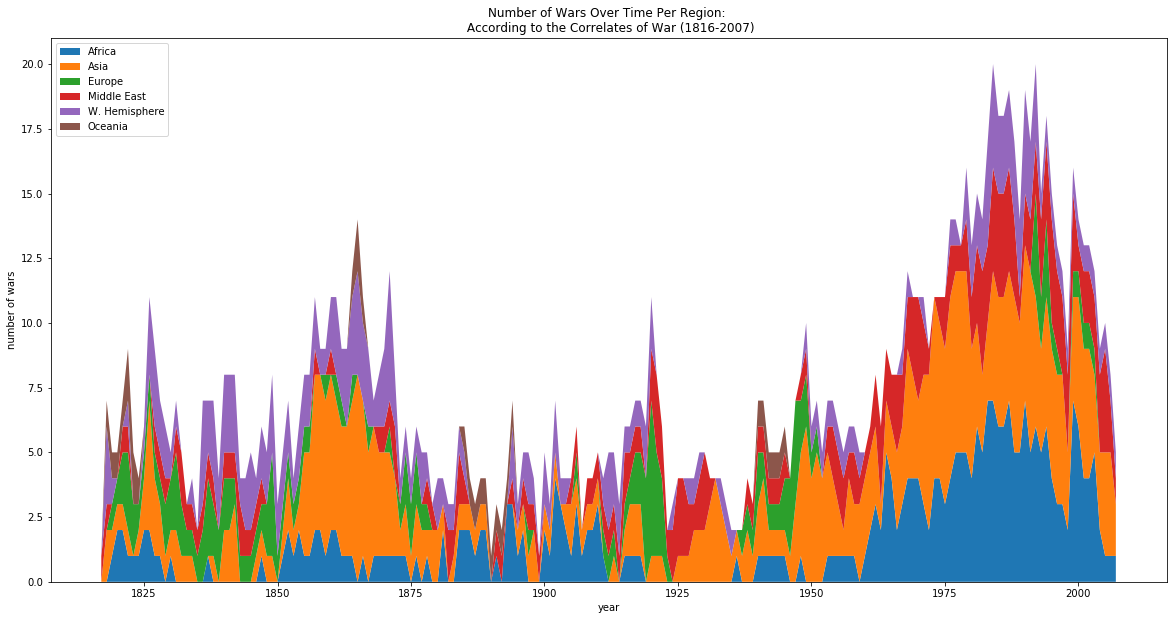

In [12]:
plt.rcParams["figure.figsize"] = (20,10)
plt.stackplot(cow_regions_toplot['year'], cow_regions_toplot['Africa'], cow_regions_toplot['Asia'], cow_regions_toplot['Europe'], 
              cow_regions_toplot['Middle East'], cow_regions_toplot['W. Hemisphere'], cow_regions_toplot['Oceania'], 
             labels=['Africa', 'Asia', 'Europe', 'Middle East', 'W. Hemisphere', 'Oceania'])
plt.legend(loc='upper left')
plt.xlabel('year')
plt.ylabel('number of wars')
plt.title('Number of Wars Over Time Per Region: \n According to the Correlates of War (1816-2007)')
plt.show()

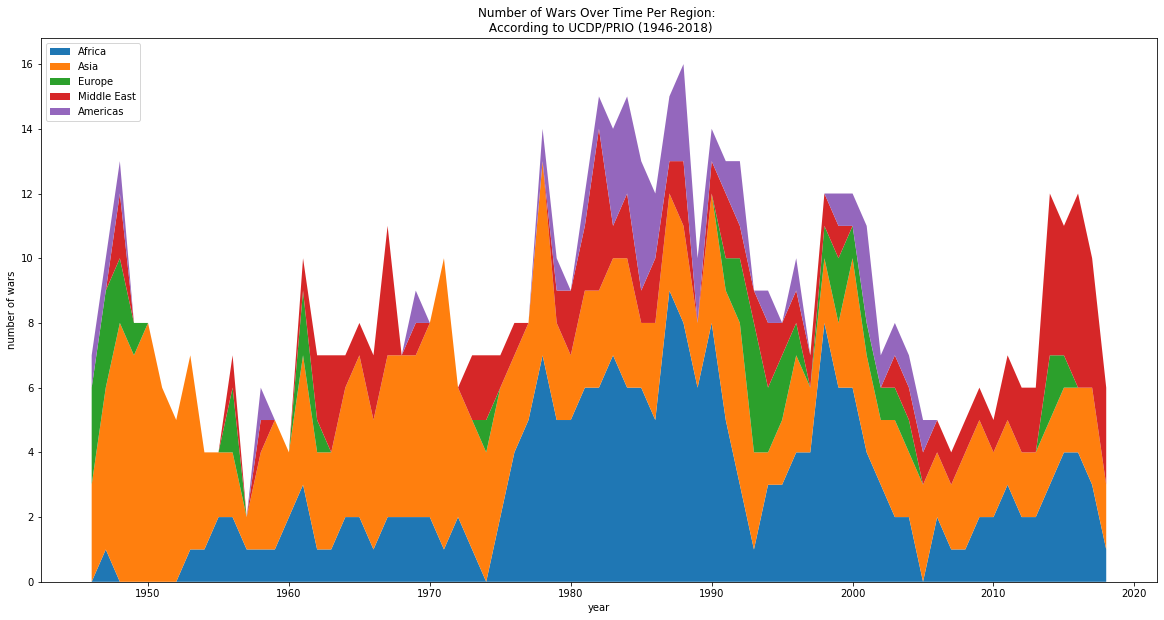

In [13]:
plt.rcParams["figure.figsize"] = (20,10)
plt.stackplot(ucdp_regions_toplot['year'], ucdp_regions_toplot['Africa'], ucdp_regions_toplot['Asia'], ucdp_regions_toplot['Europe'], 
              ucdp_regions_toplot['Middle East'], ucdp_regions_toplot['Americas'], 
             labels=['Africa', 'Asia', 'Europe', 'Middle East', 'Americas'])
plt.legend(loc='upper left')
plt.xlabel('year')
plt.ylabel('number of wars')
plt.title('Number of Wars Over Time Per Region: \n According to UCDP/PRIO (1946-2018)')
plt.show()

In [14]:
cow_type_toplot.columns

Index(['year', 'Extra-State War ', 'Inter-State War ', 'Intra-State War ',
       'Non-State War '],
      dtype='object', name='WarType')

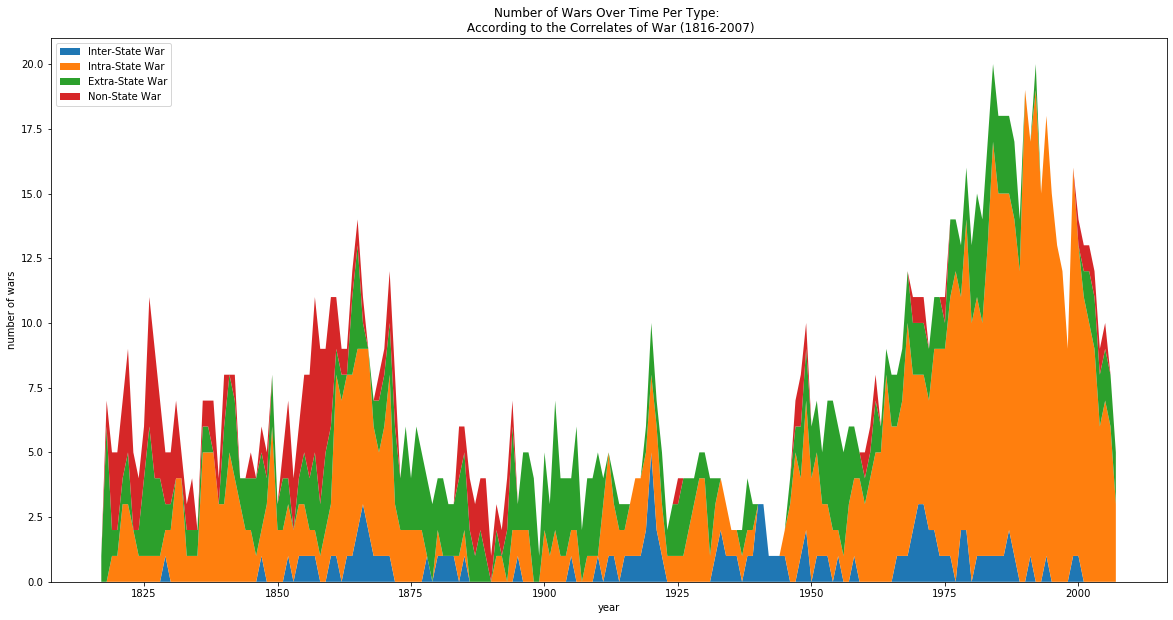

In [15]:
plt.rcParams["figure.figsize"] = (20,10)
plt.stackplot(cow_type_toplot['year'], cow_type_toplot['Inter-State War '], cow_type_toplot['Intra-State War '], 
              cow_type_toplot['Extra-State War '], cow_type_toplot['Non-State War '], 
             labels=['Inter-State War', 'Intra-State War', 'Extra-State War', 'Non-State War'])
plt.legend(loc='upper left')
plt.xlabel('year')
plt.ylabel('number of wars')
plt.title('Number of Wars Over Time Per Type: \n According to the Correlates of War (1816-2007)')
plt.show()

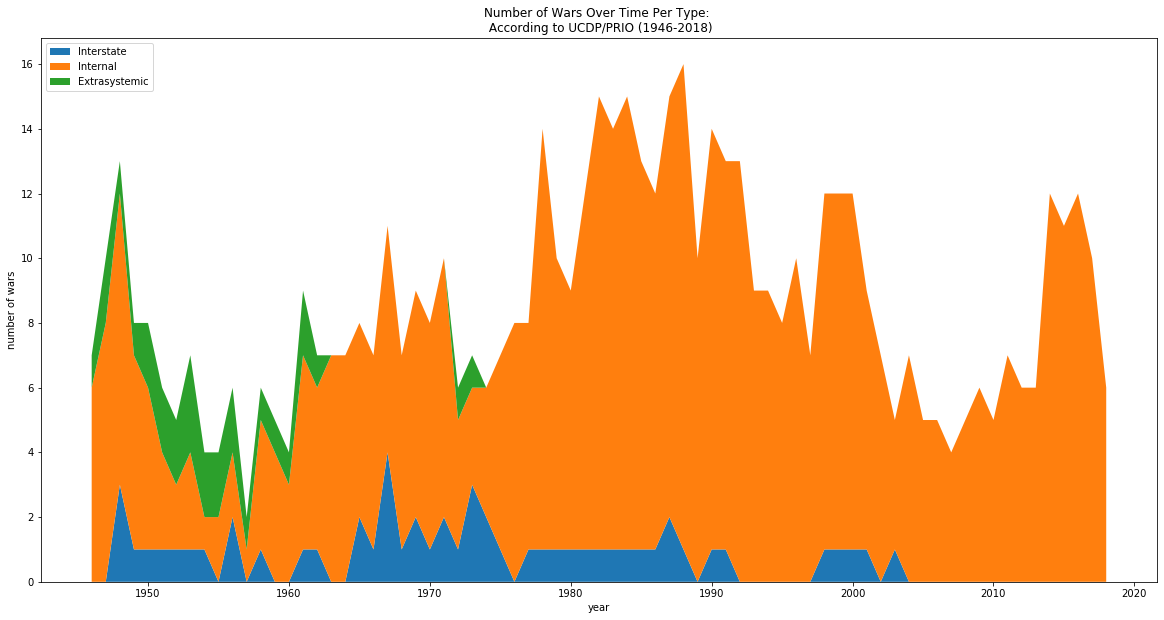

In [16]:
plt.rcParams["figure.figsize"] = (20,10)
plt.stackplot(ucdp_type_toplot['year'], ucdp_type_toplot['Interstate'], ucdp_type_toplot['Internal'], 
              ucdp_type_toplot['Extrasystemic'], 
             labels=['Interstate', 'Internal', 'Extrasystemic'])
plt.legend(loc='upper left')
plt.xlabel('year')
plt.ylabel('number of wars')
plt.title('Number of Wars Over Time Per Type: \n According to UCDP/PRIO (1946-2018)')
plt.show()